# 05 - Capability Learning: Procedural Memory for AI Agents

In the previous notebook, we saw how the Worker RPC Bridge executes code safely and captures traces.

Now let's see how those **traces become reusable capabilities** through the Procedural Memory System.

## Learning Objectives

After this notebook, you will:

- [ ] Understand the 3 types of human memory and how they map to AI systems
- [ ] Learn **Eager Learning**: capabilities stored on first successful execution
- [ ] See how code deduplication works via SHA-256 hashing
- [ ] Explore **Reliability Tracking** with success_rate metrics
- [ ] Query capabilities by semantic intent similarity

---

## The Three Types of Human Memory

Cognitive science identifies three distinct memory systems in humans:

| Type | Description | AI Equivalent | Example |
|------|-------------|---------------|--------|
| **Semantic Memory** | Facts and knowledge | RAG, Vector DBs | "Paris is the capital of France" |
| **Episodic Memory** | Personal experiences | Conversation history | "Yesterday I debugged the auth module" |
| **Procedural Memory** | Skills and "how-to" | **Nobody does this... until now!** | "How to ride a bike" |

### The Missing Piece

Most AI systems focus on **semantic** (RAG) and **episodic** (chat history) memory.

But **procedural memory** - the ability to "learn to do" rather than just "know facts" - is largely unexplored.

### The Bike Analogy

Think about learning to ride a bike:

- **Semantic**: "A bike has two wheels and handlebars" (facts)
- **Episodic**: "I remember falling off my bike when I was 6" (events)
- **Procedural**: The actual muscle memory of balancing and pedaling (skills)

You can't learn to ride a bike by reading about it. You have to **do it**.

Similarly, an AI agent can't truly learn capabilities by just storing facts about code.
It needs to **execute code**, **observe success/failure**, and **remember what worked**.

         CAPABILITY LEARNING CYCLE

Key insight: Capabilities are stored on FIRST success,
not after repeated patterns. This is 'Eager Learning'.



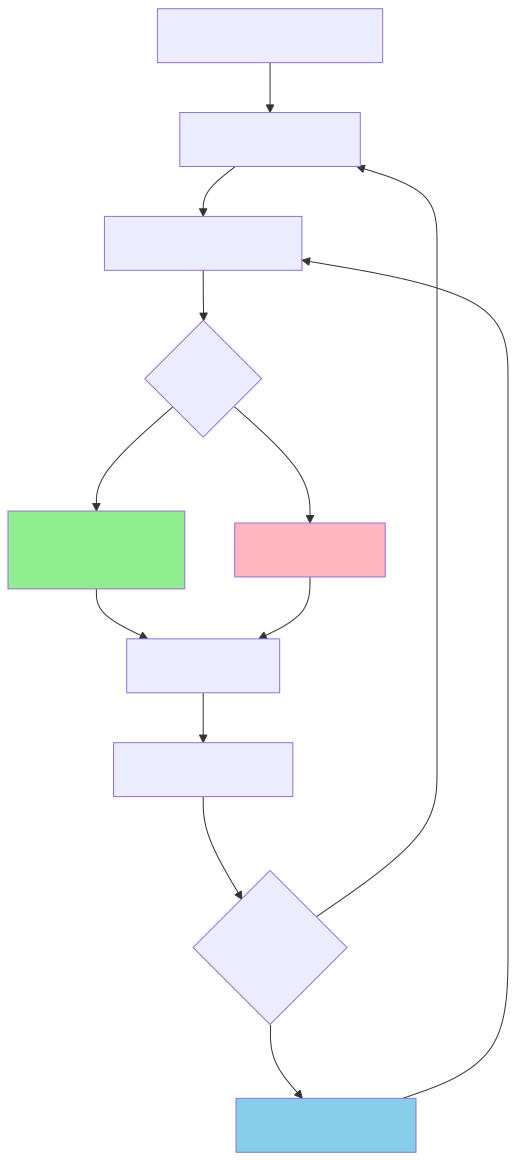

In [44]:
// Visualize the Capability Learning Cycle
import { displayMermaid } from "../lib/viz.ts";

const capabilityCycleDiagram = `
flowchart TB
    I["Intent: 'read config file'"] --> C[Code Generation]
    C --> E[Sandbox Execution]
    E --> T{Success?}
    T -->|Yes| S["Store Capability\n(Eager Learning)"]
    T -->|No| F[Track Failure]
    S --> U[Update Stats]
    F --> U
    U --> N[Next Execution...]
    N -->|Same Intent| M{Match Found?}
    M -->|Yes| R[Reuse Capability]
    M -->|No| C
    R --> E
    
    style S fill:#90EE90
    style F fill:#FFB6C1
    style R fill:#87CEEB
`;

console.log("=".repeat(60));
console.log("         CAPABILITY LEARNING CYCLE");
console.log("=".repeat(60));
console.log();
console.log("Key insight: Capabilities are stored on FIRST success,");
console.log("not after repeated patterns. This is 'Eager Learning'.");
console.log();

await displayMermaid(capabilityCycleDiagram);

---

## Eager Learning: Store on First Success (ADR-028)

Traditional pattern learning waits for repeated occurrences before storing.

**Casys PML uses Eager Learning instead:**

```
+-------------------------------------------------------------------+
|  1st SUCCESSFUL EXECUTION                                         |
+-------------------------------------------------------------------+
|                                                                   |
|  Code executed with success                                       |
|       |                                                           |
|       v                                                           |
|  hashCode(normalizedCode) -> code_hash (SHA-256)                  |
|       |                                                           |
|       v                                                           |
|  embeddingModel.encode(intent) -> intent_embedding                |
|       |                                                           |
|       v                                                           |
|  INSERT INTO workflow_pattern                                     |
|    ON CONFLICT (code_hash) DO UPDATE                              |
|      usage_count = usage_count + 1                                |
|      success_rate = success_count / usage_count                   |
|                                                                   |
|  [OK] Capability IMMEDIATELY available for reuse                  |
|                                                                   |
+-------------------------------------------------------------------+
```

### Why Eager Learning?

1. **Storage is cheap** (~2KB per capability)
2. **Filtering is lazy** (done at suggestion time, not storage time)
3. **One-shot discoveries** (valuable capabilities may only be needed once)
4. **Natural deduplication** (ON CONFLICT by code_hash)

---

## Live Demo: SimulatedCapabilityStore

For this notebook, we'll use a simplified in-memory implementation that demonstrates the key concepts.

The real `CapabilityStore` uses:
- PGlite (PostgreSQL WASM) for persistence
- BGE-M3 embeddings for semantic search
- Vector similarity for intent matching

Our simulation uses:
- Map for in-memory storage
- SHA-256 for code hashing
- Keyword matching for intent similarity

In [45]:
// SimulatedCapabilityStore - demonstrates the core concepts
// See: src/capabilities/capability-store.ts for production implementation

interface SimulatedCapability {
  id: string;
  codeHash: string;
  codeSnippet: string;
  name: string;
  intent: string;
  usageCount: number;
  successCount: number;
  successRate: number;
  avgDurationMs: number;
  createdAt: Date;
  lastUsed: Date;
  source: "emergent" | "manual";
}

class SimulatedCapabilityStore {
  private capabilities = new Map<string, SimulatedCapability>();
  private nameCounter = 0;

  private async hashCode(code: string): Promise<string> {
    const normalized = code.trim().replace(/\s+/g, " ");
    const data = new TextEncoder().encode(normalized);
    const hashBuffer = await crypto.subtle.digest("SHA-256", data);
    const hashArray = Array.from(new Uint8Array(hashBuffer));
    return hashArray.map(b => b.toString(16).padStart(2, "0")).join("");
  }

  private generateName(intent: string): string {
    const words = intent.toLowerCase()
      .replace(/[^a-z0-9\s]/g, "")
      .split(/\s+/)
      .filter(w => w.length > 2)
      .slice(0, 3);
    return words.join("_") || `capability_${++this.nameCounter}`;
  }

  async saveCapability(input: {
    code: string;
    intent: string;
    success: boolean;
    durationMs: number;
  }): Promise<{ capability: SimulatedCapability; isNew: boolean }> {
    const codeHash = await this.hashCode(input.code);
    const existing = this.capabilities.get(codeHash);

    if (existing) {
      existing.usageCount++;
      if (input.success) existing.successCount++;
      existing.successRate = existing.successCount / existing.usageCount;
      existing.avgDurationMs = 
        (existing.avgDurationMs * (existing.usageCount - 1) + input.durationMs) / existing.usageCount;
      existing.lastUsed = new Date();
      return { capability: existing, isNew: false };
    }

    const capability: SimulatedCapability = {
      id: crypto.randomUUID(),
      codeHash,
      codeSnippet: input.code,
      name: this.generateName(input.intent),
      intent: input.intent,
      usageCount: 1,
      successCount: input.success ? 1 : 0,
      successRate: input.success ? 1.0 : 0.0,
      avgDurationMs: input.durationMs,
      createdAt: new Date(),
      lastUsed: new Date(),
      source: "emergent"
    };

    this.capabilities.set(codeHash, capability);
    return { capability, isNew: true };
  }

  searchByIntent(query: string, threshold = 0.3): SimulatedCapability[] {
    const queryWords = new Set(
      query.toLowerCase().split(/\s+/).filter(w => w.length > 2)
    );
    
    const results: Array<{ cap: SimulatedCapability; score: number }> = [];
    
    for (const cap of this.capabilities.values()) {
      const intentWords = new Set(
        cap.intent.toLowerCase().split(/\s+/).filter(w => w.length > 2)
      );
      
      const intersection = [...queryWords].filter(w => intentWords.has(w)).length;
      const union = new Set([...queryWords, ...intentWords]).size;
      const score = union > 0 ? intersection / union : 0;
      
      if (score >= threshold) {
        results.push({ cap, score });
      }
    }
    
    return results
      .sort((a, b) => b.score - a.score || b.cap.usageCount - a.cap.usageCount)
      .map(r => r.cap);
  }

  getAllCapabilities(): SimulatedCapability[] {
    return [...this.capabilities.values()]
      .sort((a, b) => b.usageCount - a.usageCount);
  }

  async getByHash(code: string): Promise<SimulatedCapability | undefined> {
    const hash = await this.hashCode(code);
    return this.capabilities.get(hash);
  }

  reset(): void {
    this.capabilities.clear();
    this.nameCounter = 0;
  }

  get size(): number {
    return this.capabilities.size;
  }
}

const capabilityStore = new SimulatedCapabilityStore();

console.log("=".repeat(50));
console.log("       SIMULATED CAPABILITY STORE READY");
console.log("=".repeat(50));
console.log();
console.log("Methods:");
console.log("  - saveCapability({ code, intent, success, durationMs })");
console.log("  - searchByIntent(query, threshold?)");
console.log("  - getAllCapabilities()");
console.log();
console.log("Store size:", capabilityStore.size);

       SIMULATED CAPABILITY STORE READY

Methods:
  - saveCapability({ code, intent, success, durationMs })
  - searchByIntent(query, threshold?)
  - getAllCapabilities()

Store size: 0


---

## Demo 1: Eager Learning in Action

Let's execute code and see how it becomes a capability **immediately** on first success.

In [46]:
capabilityStore.reset();

console.log("=".repeat(60));
console.log("    DEMO 1: EAGER LEARNING - First Execution");
console.log("=".repeat(60));
console.log();

const codeSnippet1 = `
const file = await mcp.filesystem.read_file({ path: "/config.json" });
const config = JSON.parse(file.content);
return config.version;
`;

console.log("Intent: 'read and parse config file'");
console.log();
console.log("Code:");
console.log("-".repeat(60));
console.log(codeSnippet1.trim());
console.log("-".repeat(60));
console.log();

const result1 = await capabilityStore.saveCapability({
  code: codeSnippet1,
  intent: "read and parse config file",
  success: true,
  durationMs: 150
});

console.log("Result:");
console.log(`  isNew: ${result1.isNew} << CAPABILITY CREATED!`);
console.log();
console.log("Stored:");
console.log(JSON.stringify({
  name: result1.capability.name,
  codeHash: result1.capability.codeHash.substring(0, 16) + "...",
  usageCount: result1.capability.usageCount,
  successRate: result1.capability.successRate,
  source: result1.capability.source
}, null, 2));
console.log();
console.log("Store size:", capabilityStore.size);
console.log();
console.log(">> Capability stored on FIRST success. No waiting for patterns.");

    DEMO 1: EAGER LEARNING - First Execution

Intent: 'read and parse config file'

Code:
------------------------------------------------------------
const file = await mcp.filesystem.read_file({ path: "/config.json" });
const config = JSON.parse(file.content);
return config.version;
------------------------------------------------------------

Result:
  isNew: true << CAPABILITY CREATED!

Stored:
{
  "name": "read_and_parse",
  "codeHash": "3d8346af327df5f2...",
  "usageCount": 1,
  "successRate": 1,
  "source": "emergent"
}

Store size: 1

>> Capability stored on FIRST success. No waiting for patterns.


In [47]:
console.log("=".repeat(60));
console.log("    DEMO 2: CODE DEDUPLICATION via Hash");
console.log("=".repeat(60));
console.log();

// Same code, different intent
const codeSnippet2 = `
const file = await mcp.filesystem.read_file({ path: "/config.json" });
const config = JSON.parse(file.content);
return config.version;
`;

console.log("Executing SAME code with DIFFERENT intent:");
console.log("  New intent: 'get version from JSON file'");
console.log();

const result2 = await capabilityStore.saveCapability({
  code: codeSnippet2,
  intent: "get version from JSON file",
  success: true,
  durationMs: 120
});

console.log("Result:");
console.log(`  isNew: ${result2.isNew} << HIT BY CODE HASH!`);
console.log();
console.log("Updated stats:");
console.log(JSON.stringify({
  name: result2.capability.name,
  usageCount: result2.capability.usageCount,
  successRate: result2.capability.successRate,
  avgDurationMs: result2.capability.avgDurationMs.toFixed(0) + "ms"
}, null, 2));
console.log();
console.log("Store size:", capabilityStore.size, "(still 1 - deduplicated!)");
console.log();
console.log(">> Same code = same hash = same capability");
console.log(">> ON CONFLICT (code_hash) DO UPDATE");

    DEMO 2: CODE DEDUPLICATION via Hash

Executing SAME code with DIFFERENT intent:
  New intent: 'get version from JSON file'

Result:
  isNew: false << HIT BY CODE HASH!

Updated stats:
{
  "name": "read_and_parse",
  "usageCount": 2,
  "successRate": 1,
  "avgDurationMs": "135ms"
}

Store size: 1 (still 1 - deduplicated!)

>> Same code = same hash = same capability
>> ON CONFLICT (code_hash) DO UPDATE


In [48]:
console.log("=".repeat(60));
console.log("    DEMO 3: SEARCH BY INTENT");
console.log("=".repeat(60));
console.log();

// Add more capabilities
await capabilityStore.saveCapability({
  code: `const users = await mcp.memory.get_entity({ name: "users" });\nreturn users.data;`,
  intent: "get users from memory",
  success: true,
  durationMs: 50
});

await capabilityStore.saveCapability({
  code: `await mcp.filesystem.write_file({ path: "/output.txt", content: data });`,
  intent: "write output to file",
  success: true,
  durationMs: 80
});

console.log("Store size:", capabilityStore.size);
console.log();

const searchQuery = "read config JSON";
console.log(`Searching: "${searchQuery}"`);
console.log();

const searchResults = capabilityStore.searchByIntent(searchQuery);

console.log("Results:");
console.log("-".repeat(60));
for (const cap of searchResults) {
  console.log(`  [+] ${cap.name}`);
  console.log(`      Intent: "${cap.intent}"`);
  console.log(`      Usage: ${cap.usageCount}x | Success: ${(cap.successRate * 100).toFixed(0)}%`);
  console.log();
}
console.log("-".repeat(60));
console.log();
console.log(">> Production uses BGE-M3 embeddings for semantic similarity.");
console.log(">> This demo uses keyword overlap (Jaccard).");

    DEMO 3: SEARCH BY INTENT

Store size: 3

Searching: "read config JSON"

Results:
------------------------------------------------------------
  [+] read_and_parse
      Intent: "read and parse config file"
      Usage: 2x | Success: 100%

------------------------------------------------------------

>> Production uses BGE-M3 embeddings for semantic similarity.
>> This demo uses keyword overlap (Jaccard).


---

## Demo 4: Reliability Tracking

Capabilities track their **success rate** over multiple executions.

The system uses this to:
- Prioritize reliable capabilities in suggestions
- Apply adaptive thresholds (AdaptiveThresholdManager)
- Filter out flaky or broken capabilities

### Success Rate Formula

```typescript
success_rate = success_count / usage_count
```

In [49]:
console.log("=".repeat(60));
console.log("    DEMO 4: RELIABILITY TRACKING");
console.log("=".repeat(60));
console.log();

capabilityStore.reset();

const apiCode = `
const response = await mcp.fetch.get({ url: "https://api.example.com/data" });
return response.json();
`;

console.log("Simulating 10 executions (70% success rate)...");
console.log();

const executionResults = [
  { success: true,  durationMs: 200 },
  { success: true,  durationMs: 180 },
  { success: false, durationMs: 5000 },
  { success: true,  durationMs: 220 },
  { success: true,  durationMs: 190 },
  { success: false, durationMs: 5000 },
  { success: true,  durationMs: 210 },
  { success: true,  durationMs: 185 },
  { success: true,  durationMs: 195 },
  { success: false, durationMs: 5000 }
];

console.log(" # | Result | Duration |  Rate  | Trend");
console.log("-".repeat(50));

for (let i = 0; i < executionResults.length; i++) {
  const exec = executionResults[i];
  const { capability } = await capabilityStore.saveCapability({
    code: apiCode,
    intent: "fetch data from API",
    success: exec.success,
    durationMs: exec.durationMs
  });
  
  const result = exec.success ? "OK  " : "FAIL";
  const duration = exec.success ? `${exec.durationMs}ms` : "timeout";
  const rate = (capability.successRate * 100).toFixed(0);
  const barLen = Math.round(capability.successRate * 10);
  const bar = "#".repeat(barLen) + ".".repeat(10 - barLen);
  
  console.log(`${(i + 1).toString().padStart(2)} |  ${result} | ${duration.padStart(8)} | ${rate.padStart(4)}% | [${bar}]`);
}

console.log("-".repeat(50));
console.log();

const finalCap = (await capabilityStore.getByHash(apiCode))!;
console.log("Final stats:");
console.log(JSON.stringify({
  usageCount: finalCap.usageCount,
  successCount: finalCap.successCount,
  successRate: (finalCap.successRate * 100).toFixed(0) + "%",
  avgDurationMs: finalCap.avgDurationMs.toFixed(0) + "ms"
}, null, 2));
console.log();
console.log(">> success_rate guides filtering in suggestions.");

    DEMO 4: RELIABILITY TRACKING

Simulating 10 executions (70% success rate)...

 # | Result | Duration |  Rate  | Trend
--------------------------------------------------
 1 |  OK   |    200ms |  100% | [##########]
 2 |  OK   |    180ms |  100% | [##########]
 3 |  FAIL |  timeout |   67% | [#######...]
 4 |  OK   |    220ms |   75% | [########..]
 5 |  OK   |    190ms |   80% | [########..]
 6 |  FAIL |  timeout |   67% | [#######...]
 7 |  OK   |    210ms |   71% | [#######...]
 8 |  OK   |    185ms |   75% | [########..]
 9 |  OK   |    195ms |   78% | [########..]
10 |  FAIL |  timeout |   70% | [#######...]
--------------------------------------------------

Final stats:
{
  "usageCount": 10,
  "successCount": 7,
  "successRate": "70%",
  "avgDurationMs": "1638ms"
}

>> success_rate guides filtering in suggestions.


---

## Visualization: Capabilities Table

Let's create a rich dataset and display all capabilities.

In [50]:
capabilityStore.reset();

const capabilitiesData = [
  { code: "await mcp.filesystem.read_file({ path })", intent: "read file from disk", executions: 25, successRate: 0.96 },
  { code: "await mcp.memory.store_entity({ name, data })", intent: "store entity in memory", executions: 18, successRate: 1.0 },
  { code: "JSON.parse(content)", intent: "parse JSON content", executions: 42, successRate: 0.88 },
  { code: "await mcp.fetch.get({ url })", intent: "fetch data from URL", executions: 15, successRate: 0.73 },
  { code: "data.filter(x => x.active)", intent: "filter active items", executions: 8, successRate: 1.0 },
  { code: "await mcp.github.create_issue({ title, body })", intent: "create GitHub issue", executions: 5, successRate: 0.80 },
  { code: "results.map(r => r.id)", intent: "extract IDs from results", executions: 12, successRate: 1.0 },
  { code: "await mcp.database.query({ sql })", intent: "execute SQL query", executions: 3, successRate: 0.33 }
];

for (const cap of capabilitiesData) {
  const successCount = Math.round(cap.executions * cap.successRate);
  const failCount = cap.executions - successCount;
  
  for (let i = 0; i < successCount; i++) {
    await capabilityStore.saveCapability({
      code: cap.code,
      intent: cap.intent,
      success: true,
      durationMs: 50 + Math.random() * 200
    });
  }
  for (let i = 0; i < failCount; i++) {
    await capabilityStore.saveCapability({
      code: cap.code,
      intent: cap.intent,
      success: false,
      durationMs: 1000 + Math.random() * 4000
    });
  }
}

console.log("Created", capabilityStore.size, "capabilities.");

Created 8 capabilities.


In [51]:
function reliabilityLabel(rate: number): string {
  if (rate >= 0.85) return "HIGH";
  if (rate >= 0.60) return "MED ";
  return "LOW ";
}

console.log("=".repeat(75));
console.log("                     CAPABILITIES TABLE");
console.log("=".repeat(75));
console.log();

const allCaps = capabilityStore.getAllCapabilities();

console.log("| Name                    | Usage |  Rate | Duration | Level |");
console.log("|-------------------------|-------|-------|----------|-------|");

for (const cap of allCaps) {
  const name = cap.name.substring(0, 23).padEnd(23);
  const usage = (cap.usageCount.toString() + "x").padStart(5);
  const rate = ((cap.successRate * 100).toFixed(0) + "%").padStart(5);
  const duration = (cap.avgDurationMs.toFixed(0) + "ms").padStart(8);
  const level = reliabilityLabel(cap.successRate);
  
  console.log(`| ${name} | ${usage} | ${rate} | ${duration} |  ${level} |`);
}

console.log();
console.log("Reliability: HIGH (>85%) | MED (60-85%) | LOW (<60%)");
console.log("Sorted by usage_count DESC");

                     CAPABILITIES TABLE

| Name                    | Usage |  Rate | Duration | Level |
|-------------------------|-------|-------|----------|-------|
| parse_json_content      |   42x |   88% |    532ms |  HIGH |
| read_file_from          |   25x |   96% |    277ms |  HIGH |
| store_entity_memory     |   18x |  100% |    168ms |  HIGH |
| fetch_data_from         |   15x |   73% |   1217ms |  MED  |
| extract_ids_from        |   12x |  100% |    176ms |  HIGH |
| filter_active_items     |    8x |  100% |    176ms |  HIGH |
| create_github_issue     |    5x |   80% |    480ms |  MED  |
| execute_sql_query       |    3x |   33% |   1462ms |  LOW  |

Reliability: HIGH (>85%) | MED (60-85%) | LOW (<60%)
Sorted by usage_count DESC


---

## Key Takeaways

| Concept | Traditional RAG | Procedural Memory |
|---------|-----------------|-------------------|
| **Learning** | Pre-indexed docs | Runtime execution |
| **Trigger** | Query similarity | First success |
| **Dedup** | Document-level | Code hash (SHA-256) |
| **Quality** | Static relevance | Dynamic success_rate |

### Core Mechanisms

1. **Eager Learning**: Store on first success, filter later
2. **Code Hash**: SHA-256 for natural deduplication
3. **UPSERT**: `ON CONFLICT (code_hash) DO UPDATE`
4. **Reliability**: `success_rate` guides suggestions
5. **Intent Search**: BGE-M3 embeddings for semantic matching

---

## Casys PML vs Other Approaches

| Approach | Learning | Schema Inference | Reliability |
|----------|----------|------------------|-------------|
| Skill Libraries (CodeBERT) | Static | Manual | No |
| Code Retrieval (Copilot) | Pre-trained | No | No |
| Anthropic Skills | Manual | Implicit | No |
| **Casys PML** | **Runtime/Eager** | **AST Auto** | **Transitive** |

### Key Differentiators

1. **Runtime Learning**: Capabilities from execution, not pre-training
2. **Eager Storage**: First success triggers storage
3. **Automatic Schema**: SWC parses code for types
4. **Transitive Reliability**: Rates propagate through workflows

---

## Summary

### What We Learned

1. **Three Memory Types**:
   - Semantic (facts) -> RAG
   - Episodic (events) -> Chat history
   - **Procedural (skills) -> Capability Learning**

2. **Eager Learning**: Store on first success, filter at suggestion time

3. **Code Deduplication**: SHA-256 hash + UPSERT pattern

4. **Reliability Tracking**: `success_rate = success_count / usage_count`

5. **Semantic Search**: BGE-M3 embeddings for intent matching

### Paper Connection (Section 3.2)

- Eager storage on first execution
- Code hashing for deduplication
- UPSERT with statistics tracking

---

**Next:** 06-emergent-reuse.ipynb - Capability composition and reuse